## Import packages

In [853]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import loguniform, uniform
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000) 
pd.set_option('display.colheader_justify', 'center') 


# Load dataset

In [679]:
data = pd.read_csv('data/Energy_consumption.csv')
data.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


- *Month:* Represents the month of the year (1–12). Useful for categorizing month data into seasons.
- *Hour:* Hourly readings of the day (0–23), useful for categorizing time data into morning, afternoon, evening, and night.
- *DayOfWeek:* Categorical variable indicating the day of the week.
- *Holiday:* Boolean categorical variable indicating whether the day is a holiday.
- *Temperature:* Numerical variable representing the temperature in degrees Celsius.
- *Humidity:* Numerical variable showing the humidity level as a percentage.
- *SquareFootage:* Numerical variable measuring the area of the building or space.
- *Occupancy:* Numerical variable representing the number of people in the area.
- *HVACUsage:* Categorical variable indicating the usage of Heating, Ventilation, and Air Conditioning systems.
- *LightingUsage:* Categorical variable indicating the usage of lighting systems.
- *RenewableEnergy:* Numerical variable representing the percentage contribution of renewable energy sources.
- *EnergyConsumption:* Numerical target variable representing the total energy consumed.


In [682]:
data.shape

(1000, 11)

## Let's check the missing values ​​again

In [685]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB


In [686]:
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Temperature,1000.0,24.98,2.84,20.01,22.65,24.75,27.42,30.00
Humidity,1000.0,45.40,8.52,30.02,38.30,45.97,52.42,59.97
SquareFootage,1000.0,1500.05,288.42,1000.51,1247.11,1507.97,1740.34,1999.98
Occupancy,1000.0,4.58,2.87,0.00,2.00,5.00,7.00,9.00
RenewableEnergy,1000.0,15.13,8.75,0.01,7.63,15.07,22.88,29.97
EnergyConsumption,1000.0,77.06,8.14,53.26,71.54,76.94,82.92,99.20


The dataset contains several columns that are completely null and others with null values, so we'll skip all columns containing zeros and NaNs, as they're unusable. Let's check them and remove them.

In [690]:
missing = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
missing.columns=['Count', 'Percent_%']
missing.sort_values(by=['Count'],ascending = False)
missing

,Count,Percent_%
Timestamp,0,0.0
Temperature,0,0.0
Humidity,0,0.0
SquareFootage,0,0.0
Occupancy,0,0.0
HVACUsage,0,0.0
LightingUsage,0,0.0
RenewableEnergy,0,0.0
DayOfWeek,0,0.0
Holiday,0,0.0


## Convert 'Timestamp' to datetime

In [693]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month
data = data.drop(columns=['Timestamp'])

In [694]:
data.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
0,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,0,1,1
1,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,1,1,1
2,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2,1,1
3,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,3,1,1
4,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,4,1,1


# EDA

## Data Visualization

In [699]:
num_cols = data.select_dtypes(exclude = ['object']).columns
cat_cols = data.select_dtypes(include= ['object']).columns
print("Numerical features:", num_cols)
print("Categorical features:", cat_cols)

Numerical features: Index(['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'Hour', 'Day', 'Month'], dtype='object')
Categorical features: Index(['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday'], dtype='object')


## Numerical features

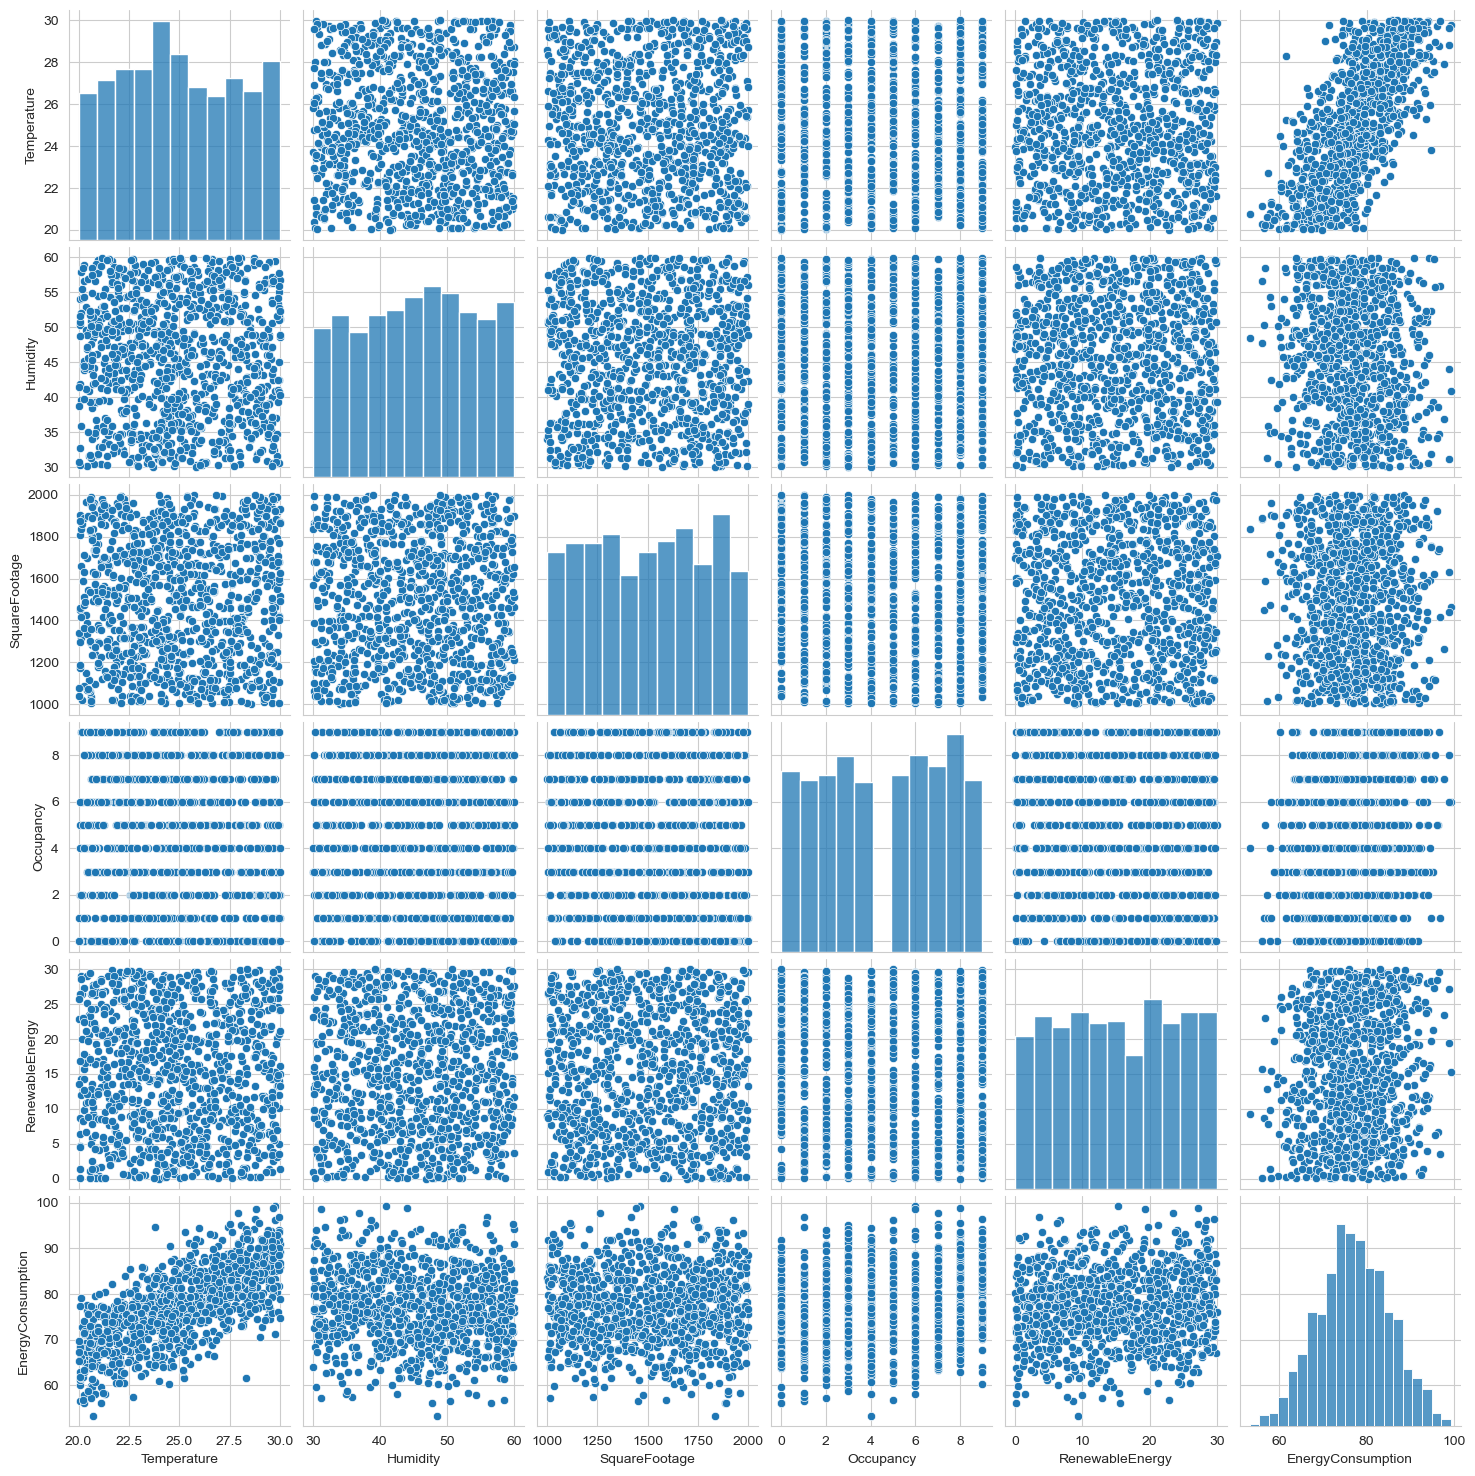

In [702]:
sns.pairplot(data[['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']])
plt.show()

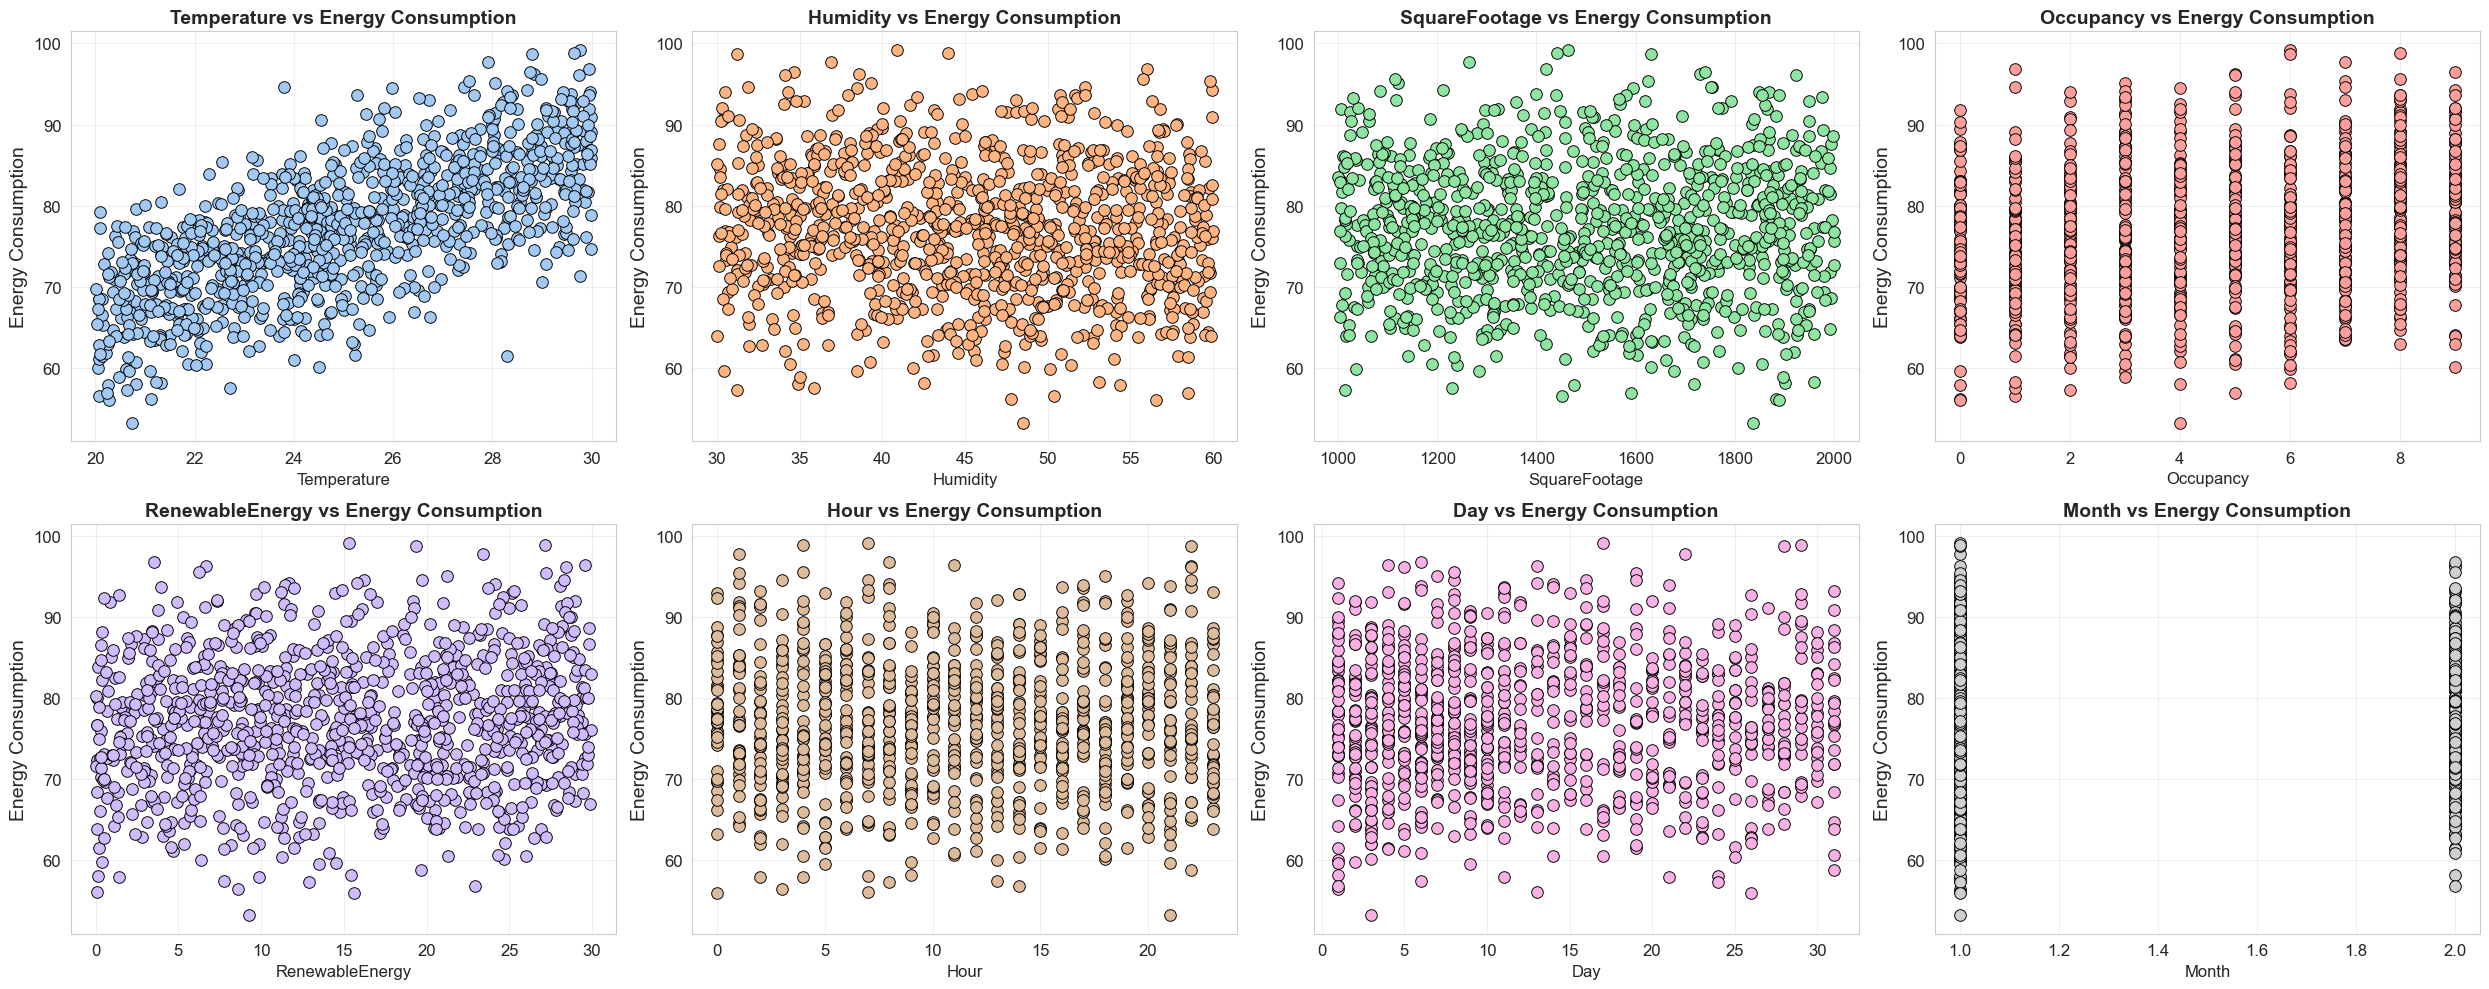

In [716]:
features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'Hour', 'Day', 'Month']

fig, ax = plt.subplots(2, 4, figsize=(25, 10))
sns.set_style("whitegrid")
ax = ax.flatten() 

colors = sns.color_palette("pastel", len(features))

for i, feature in enumerate(features):
    sns.scatterplot(
        ax=ax[i],
        x=feature,
        y='EnergyConsumption',
        data=data,
        color=colors[i],
        edgecolor="black",
        s=70
    )
    ax[i].set_title(f'{feature} vs Energy Consumption', fontsize=14, fontweight='bold')
    ax[i].set_xlabel(feature, fontsize=12)
    ax[i].set_ylabel('Energy Consumption', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].grid(alpha=0.3)

for j in range(len(features), len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

##  Outliers

To detect outliers in your data, you can use several simple methods:

- Boxplot: The boxplot displays outliers as points outside the box.

- Z-score: A value is considered an outlier if its z-score > 3 (or < -3)
(used to indicate how many standard deviations a data point lies from the mean of a data set).

- Interquartile range (IQR): A value is considered an outlier if it falls outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR].

### Categorical features

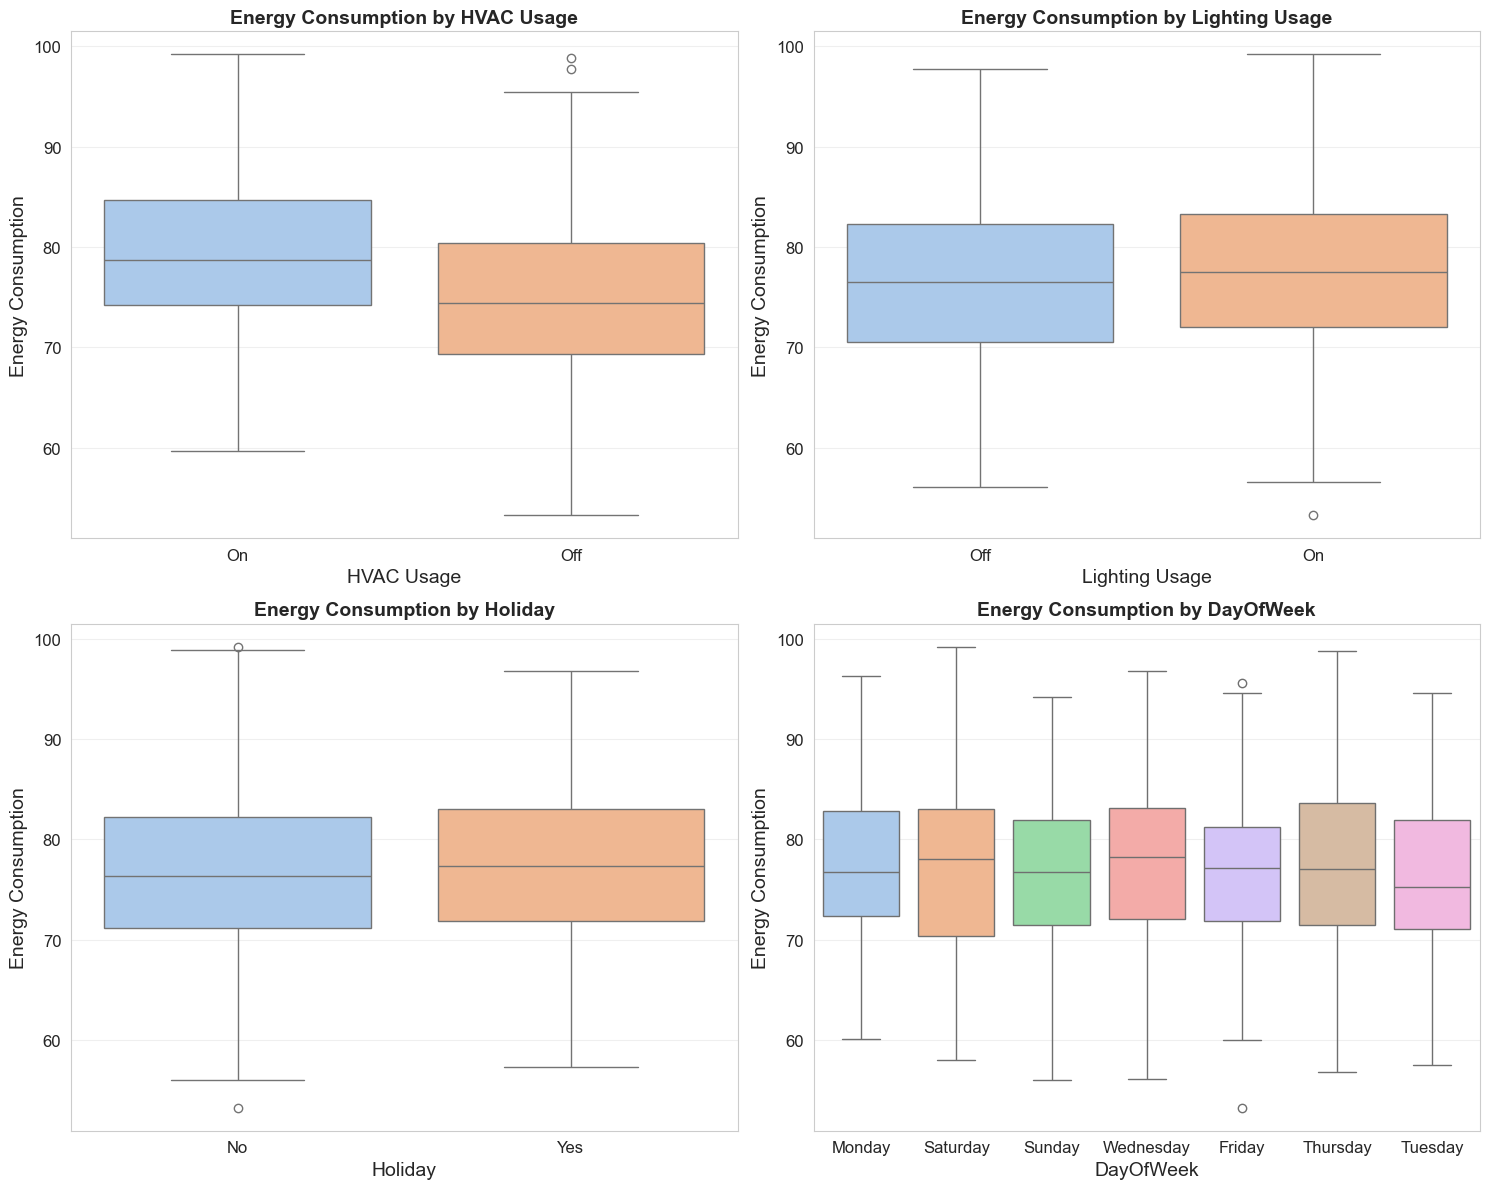

In [630]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Boxplot: HVAC Usage vs Energy Consumption
sns.boxplot(ax=ax[0,0], x='HVACUsage', y='EnergyConsumption', hue='HVACUsage', data=data, palette="pastel", legend=False)
ax[0,0].set_title('Energy Consumption by HVAC Usage', fontsize=14, fontweight='bold')
ax[0,0].set_xlabel('HVAC Usage', fontsize=14)
ax[0,0].set_ylabel('Energy Consumption', fontsize=14)
ax[0,0].tick_params(axis='x', labelsize=12)
ax[0,0].tick_params(axis='y', labelsize=12)
ax[0,0].grid(axis='y', alpha=0.3)

# Boxplot: Lighting Usage vs Energy Consumption
sns.boxplot(ax=ax[0,1], x='LightingUsage', y='EnergyConsumption', hue='LightingUsage', data=data, palette="pastel", legend=False)
ax[0,1].set_title('Energy Consumption by Lighting Usage', fontsize=14, fontweight='bold')
ax[0,1].set_xlabel('Lighting Usage', fontsize=14)
ax[0,1].set_ylabel('Energy Consumption', fontsize=14)
ax[0,1].tick_params(axis='x', labelsize=12)
ax[0,1].tick_params(axis='y', labelsize=12)
ax[0,1].grid(axis='y', alpha=0.3)

# Boxplot: Holiday vs Energy Consumption
sns.boxplot(ax=ax[1,0], x='Holiday', y='EnergyConsumption', hue='Holiday', data=data, palette="pastel", legend=False)
ax[1,0].set_title('Energy Consumption by Holiday', fontsize=14, fontweight='bold')
ax[1,0].set_xlabel('Holiday', fontsize=14)
ax[1,0].set_ylabel('Energy Consumption', fontsize=14)
ax[1,0].tick_params(axis='x', labelsize=12)
ax[1,0].tick_params(axis='y', labelsize=12)
ax[1,0].grid(axis='y', alpha=0.3)

# Boxplot: DayOfWeek vs Energy Consumption
sns.boxplot(ax=ax[1,1], x='DayOfWeek', y='EnergyConsumption', hue='DayOfWeek', data=data, palette="pastel", legend=False)
ax[1,1].set_title('Energy Consumption by DayOfWeek', fontsize=14, fontweight='bold')
ax[1,1].set_xlabel('DayOfWeek', fontsize=14)
ax[1,1].set_ylabel('Energy Consumption', fontsize=14)
ax[1,1].tick_params(axis='x', labelsize=12)
ax[1,1].tick_params(axis='y', labelsize=12)
ax[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

To remove outliers in each categorical group from your variable EnergyConsumption, you should apply the IQR (interquartile range) method within each group.

In [718]:
def remove_group_outliers(df, group_col, target_col):
    def iqr_filter(group):
        Q1 = group[target_col].quantile(0.25)
        Q3 = group[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return group[(group[target_col] >= lower) & (group[target_col] <= upper)]
    return df.groupby(group_col, group_keys=False).apply(iqr_filter)

# Remover outliers por cada variable (por separado)
data_no_out_hvac = remove_group_outliers(data, 'HVACUsage', 'EnergyConsumption')
data_no_out_light = remove_group_outliers(data, 'LightingUsage', 'EnergyConsumption')
data_no_out_holiday = remove_group_outliers(data, 'Holiday', 'EnergyConsumption')
data_no_out_dayofweek = remove_group_outliers(data, 'DayOfWeek', 'EnergyConsumption')

# Remover outliers de forma encadenada (intersección de filtros)
hvac = remove_group_outliers(data, 'HVACUsage', 'EnergyConsumption')
light = remove_group_outliers(hvac, 'LightingUsage', 'EnergyConsumption')
holiday = remove_group_outliers(light, 'Holiday', 'EnergyConsumption')
data_clean = remove_group_outliers(holiday, 'DayOfWeek', 'EnergyConsumption')

C:\Users\catas\AppData\Local\Temp\ipykernel_5648\2911880783.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(iqr_filter)
C:\Users\catas\AppData\Local\Temp\ipykernel_5648\2911880783.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(iqr_filter)
C:\Users\catas\AppData\Local\Temp\ipykernel_5648\2911880

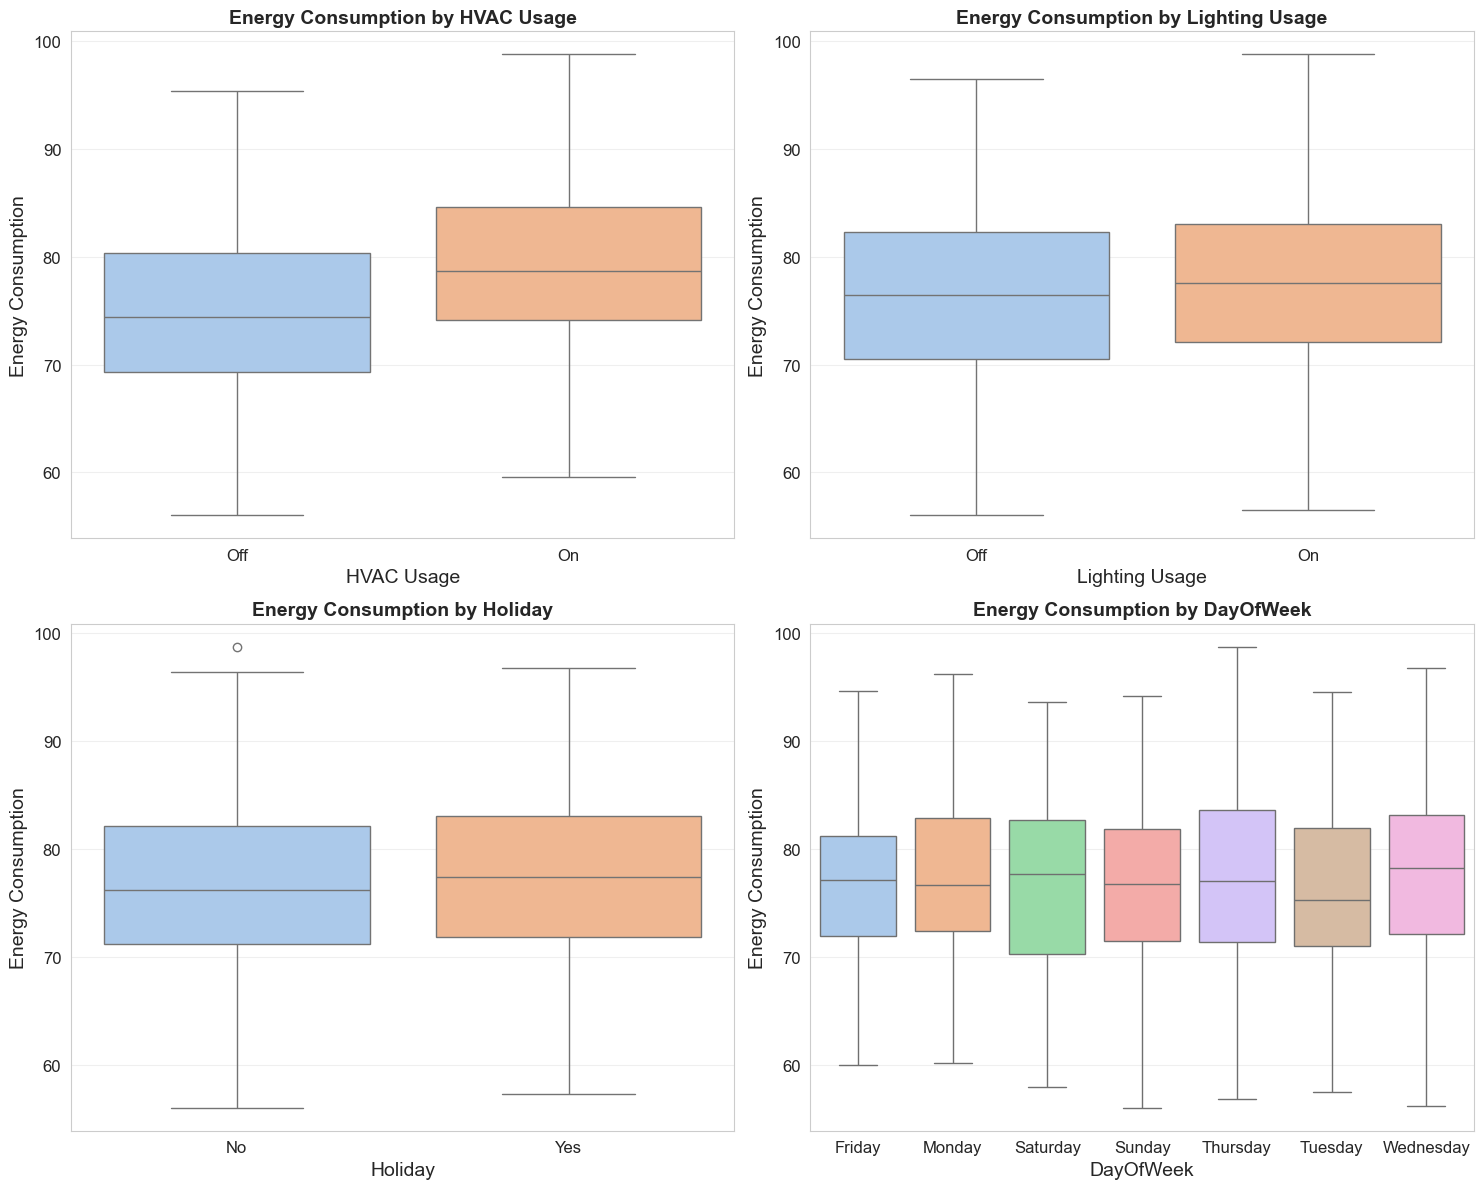

In [720]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Boxplot: HVAC Usage vs Energy Consumption
sns.boxplot(ax=ax[0,0], x='HVACUsage', y='EnergyConsumption', hue='HVACUsage', data=data_clean, palette="pastel", legend=False)
ax[0,0].set_title('Energy Consumption by HVAC Usage', fontsize=14, fontweight='bold')
ax[0,0].set_xlabel('HVAC Usage', fontsize=14)
ax[0,0].set_ylabel('Energy Consumption', fontsize=14)
ax[0,0].tick_params(axis='x', labelsize=12)
ax[0,0].tick_params(axis='y', labelsize=12)
ax[0,0].grid(axis='y', alpha=0.3)

# Boxplot: Lighting Usage vs Energy Consumption
sns.boxplot(ax=ax[0,1], x='LightingUsage', y='EnergyConsumption', hue='LightingUsage', data=data_clean, palette="pastel", legend=False)
ax[0,1].set_title('Energy Consumption by Lighting Usage', fontsize=14, fontweight='bold')
ax[0,1].set_xlabel('Lighting Usage', fontsize=14)
ax[0,1].set_ylabel('Energy Consumption', fontsize=14)
ax[0,1].tick_params(axis='x', labelsize=12)
ax[0,1].tick_params(axis='y', labelsize=12)
ax[0,1].grid(axis='y', alpha=0.3)

# Boxplot: Holiday vs Energy Consumption
sns.boxplot(ax=ax[1,0], x='Holiday', y='EnergyConsumption', hue='Holiday', data=data_clean, palette="pastel", legend=False)
ax[1,0].set_title('Energy Consumption by Holiday', fontsize=14, fontweight='bold')
ax[1,0].set_xlabel('Holiday', fontsize=14)
ax[1,0].set_ylabel('Energy Consumption', fontsize=14)
ax[1,0].tick_params(axis='x', labelsize=12)
ax[1,0].tick_params(axis='y', labelsize=12)
ax[1,0].grid(axis='y', alpha=0.3)

# Boxplot: DayOfWeek vs Energy Consumption
sns.boxplot(ax=ax[1,1], x='DayOfWeek', y='EnergyConsumption', hue='DayOfWeek', data=data_clean, palette="pastel", legend=False)
ax[1,1].set_title('Energy Consumption by DayOfWeek', fontsize=14, fontweight='bold')
ax[1,1].set_xlabel('DayOfWeek', fontsize=14)
ax[1,1].set_ylabel('Energy Consumption', fontsize=14)
ax[1,1].tick_params(axis='x', labelsize=12)
ax[1,1].tick_params(axis='y', labelsize=12)
ax[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

These plots provide an overview of the balance and distribution in key categorical features, useful for identifying potential data biases or ensuring sufficient representation across categories before modeling or deeper analysis.

- *DayOfWeek*:
Displays the distribution of records across the days of the week. The counts for each day (Saturday, Sunday, Monday, Tuesday, Wednesday, Thursday, and Friday) are fairly uniform, indicating that the data is evenly distributed across the week.

- *Holiday*: Shows the count of records for Holiday status ("No" or "Yes"). There are more records for non-holidays ("No") than holidays ("Yes").

- *HVACUsage*:
Illustrates whether HVAC systems were "On" or "Off".The counts for "On" and "Off" are almost equal, suggesting balanced data regarding HVAC usage.

- *LightingUsage*:
Displays whether lighting was "On" or "Off". The counts for both categories are similar, with "Off" slightly higher than "On".

### Numerical features

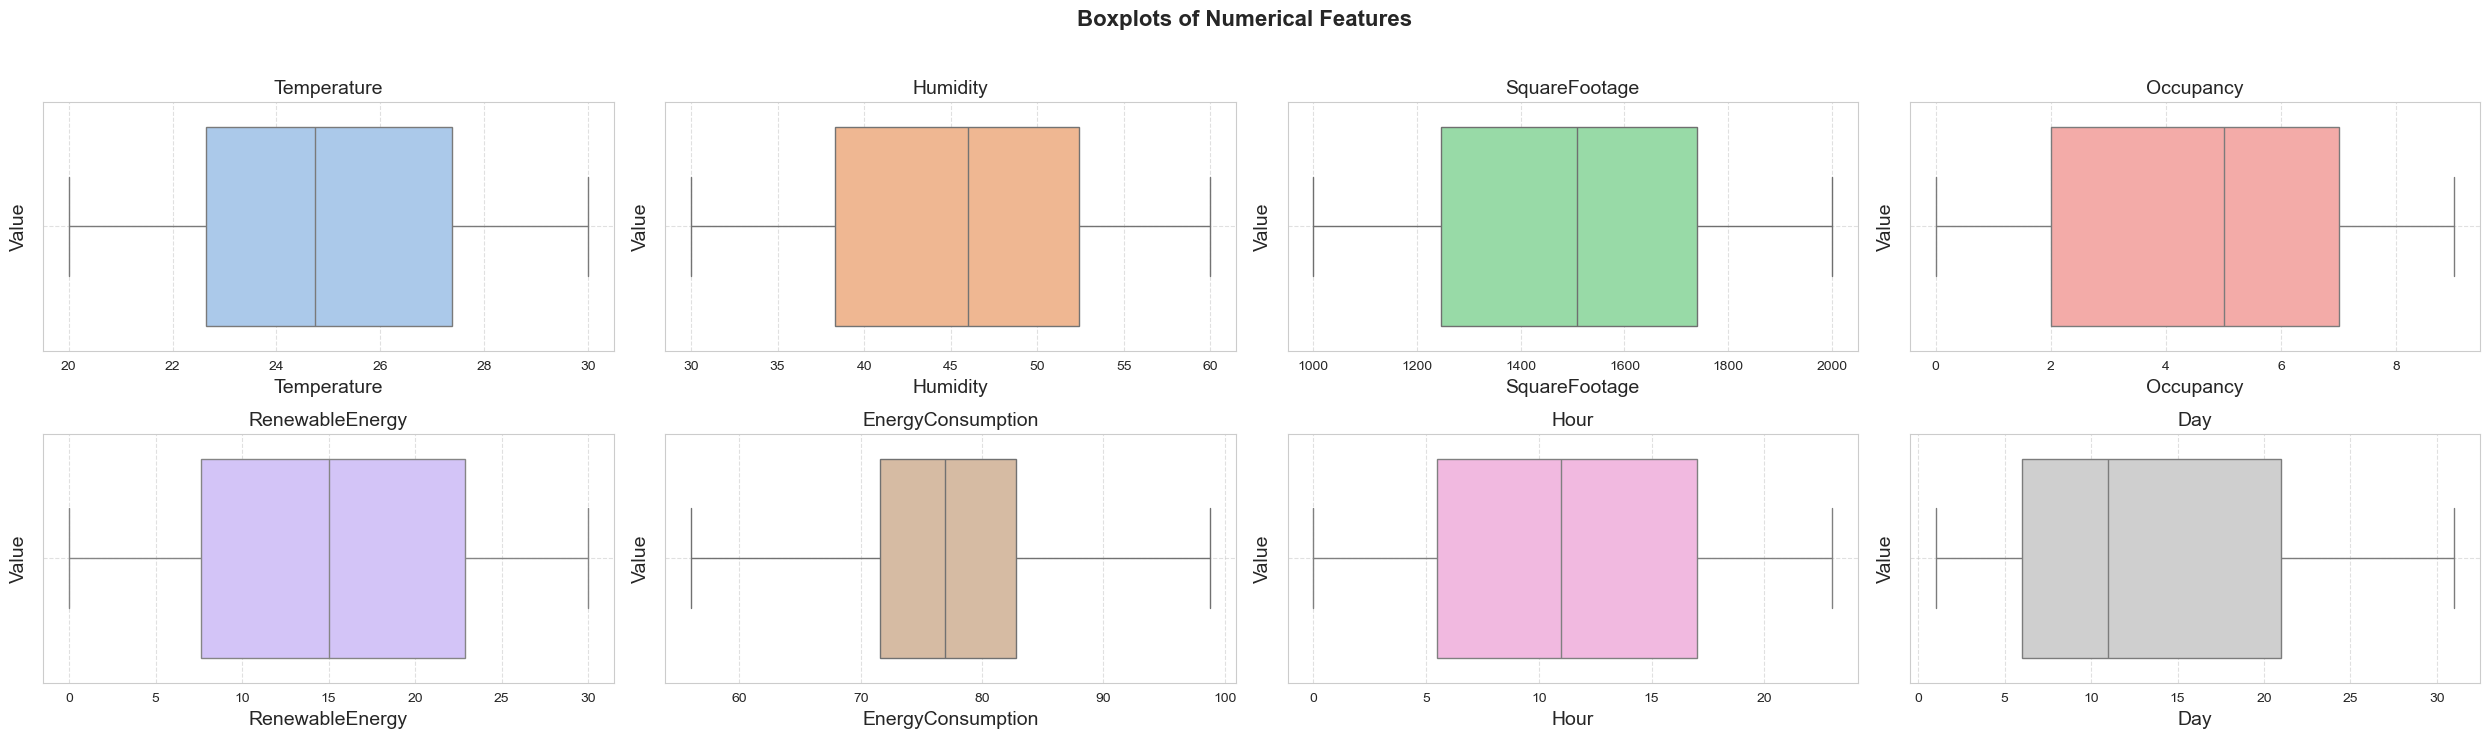

In [742]:
numerical_columns = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'Hour', 'Day']

pastel_colors = sns.color_palette("pastel", len(numerical_columns))

f, ax = plt.subplots(3, 4, figsize=(25, 10), sharey=False)
ax = ax.flatten()

for index, col in enumerate(numerical_columns):
    sns.boxplot(data=data_clean, x=col, ax=ax[index], color=pastel_colors[index])
    ax[index].set_title(col, fontsize=14)
    ax[index].set_xlabel(col, fontsize=14)
    ax[index].set_ylabel("Value", fontsize=14)
    ax[index].grid(True, linestyle="--", alpha=0.6)

for i in range(len(numerical_columns), len(ax)):
    ax[i].set_visible(False)

f.suptitle('Boxplots of Numerical Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [744]:
from scipy.stats import zscore
# Calculate Z-scores for numerical columns
z_scores = data_clean[numerical_columns].apply(zscore)

# Identify outliers (z-score > 3 or z-score < -3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of outliers detected using Z-scores: {outliers.sum()}")

# Display rows that are considered outliers
outliers_data = data_clean[outliers]
print(outliers_data)

Number of outliers detected using Z-scores: 0
Empty DataFrame
Columns: [Temperature, Humidity, SquareFootage, Occupancy, HVACUsage, LightingUsage, RenewableEnergy, DayOfWeek, Holiday, EnergyConsumption, Hour, Day, Month]
Index: []


In [746]:
# Calculate IQR for numerical columns
Q1 = data_clean[numerical_columns].quantile(0.25)
Q3 = data_clean[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using IQR
outliers = ((data_clean[numerical_columns] < (Q1 - 1.5 * IQR)) | (data_clean[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of outliers detected using IQR: {outliers.sum()}")

# Display rows that are considered outliers
outliers_data = data_clean[outliers]
print(outliers_data)

Number of outliers detected using IQR: 0
Empty DataFrame
Columns: [Temperature, Humidity, SquareFootage, Occupancy, HVACUsage, LightingUsage, RenewableEnergy, DayOfWeek, Holiday, EnergyConsumption, Hour, Day, Month]
Index: []


In [748]:
data_clean.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
51,22.124214,47.343916,1919.119996,6,Off,Off,5.352019,Friday,No,62.001894,3,3,1
72,25.080881,59.671534,1897.702224,8,Off,Off,14.391800,Friday,No,75.913906,0,4,1
97,20.979909,58.115629,1179.486192,9,Off,Off,8.577366,Friday,No,70.714362,1,5,1
185,29.954995,55.096539,1107.202980,5,Off,Off,26.994040,Friday,No,86.087469,17,8,1
228,28.298295,45.344931,1908.788264,0,Off,Off,11.433880,Friday,No,77.877691,12,10,1


## Convert categorical variables

It is used to convert categorical variables (labels) into numeric values, assigning an integer to each distinct category.

Ordinal → LabelEncoder, like down,medium,high, turn each category into unique number.

Nominal → One-Hot Encoding, like city, gender, country, creating binary colums by category.

In [752]:
num_cols = data_clean.select_dtypes(exclude = ['object']).columns
cat_cols = data_clean.select_dtypes(include= ['object']).columns
print("Numerical features:", num_cols)
print("Categorical features:", cat_cols)

Numerical features: Index(['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'Hour', 'Day', 'Month'], dtype='object')
Categorical features: Index(['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday'], dtype='object')


In [754]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'day' column
data_clean['HVACUsage'] = label_encoder.fit_transform(data_clean['HVACUsage'])
data_clean['LightingUsage'] = label_encoder.fit_transform(data_clean['LightingUsage'])
data_clean['Holiday'] = label_encoder.fit_transform(data_clean['Holiday'])
#df['DayOfWeek'] = label_encoder.fit_transform(df['DayOfWeek']) # Nota: esto asigna números alfabéticamente, no por orden de días

day_categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_clean['DayOfWeek'] = pd.Categorical(data_clean['DayOfWeek'], categories=day_categories, ordered=True)
data_clean['DayOfWeek'] = data_clean['DayOfWeek'].cat.codes + 1
data_clean.dtypes
data_clean.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
51,22.124214,47.343916,1919.119996,6,0,0,5.352019,5,0,62.001894,3,3,1
72,25.080881,59.671534,1897.702224,8,0,0,14.391800,5,0,75.913906,0,4,1
97,20.979909,58.115629,1179.486192,9,0,0,8.577366,5,0,70.714362,1,5,1
185,29.954995,55.096539,1107.202980,5,0,0,26.994040,5,0,86.087469,17,8,1
228,28.298295,45.344931,1908.788264,0,0,0,11.433880,5,0,77.877691,12,10,1


## Correlation

In [824]:
numerical_features = [
    'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 
    'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek', 
    'Holiday', 'Hour', 'Day', 'Month', 'EnergyConsumption']

In [826]:
data_clean.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Temperature,995.0,24.97,2.83,20.01,22.64,24.74,27.38,30.00
Humidity,995.0,45.40,8.53,30.02,38.29,45.98,52.42,59.97
SquareFootage,995.0,1500.43,288.58,1000.51,1246.28,1508.40,1740.47,1999.98
Occupancy,995.0,4.57,2.87,0.00,2.00,5.00,7.00,9.00
HVACUsage,995.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
LightingUsage,995.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
RenewableEnergy,995.0,15.13,8.75,0.01,7.62,15.04,22.85,29.97
DayOfWeek,995.0,4.12,1.98,1.00,2.00,4.00,6.00,7.00
Holiday,995.0,0.47,0.50,0.00,0.00,0.00,1.00,1.00
EnergyConsumption,995.0,77.00,8.02,56.04,71.54,76.94,82.77,98.76


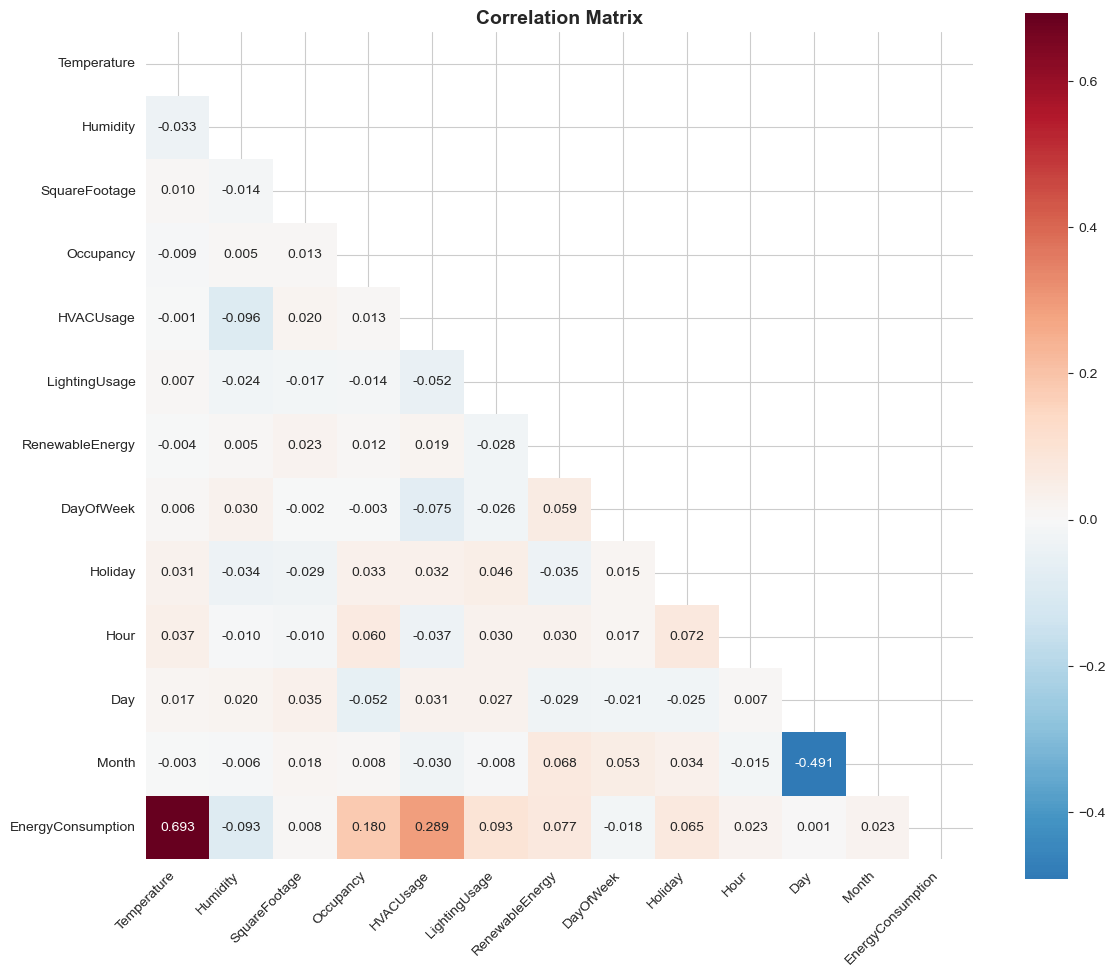

Correlations with EnergyConsumption:
----------------------------------------
Temperature     |   0.693
HVACUsage       |   0.289
Occupancy       |   0.180
LightingUsage   |   0.093
Humidity        |  -0.093
RenewableEnergy |   0.077
Holiday         |   0.065
Hour            |   0.023
Month           |   0.023
DayOfWeek       |  -0.018
SquareFootage   |   0.008
Day             |   0.001


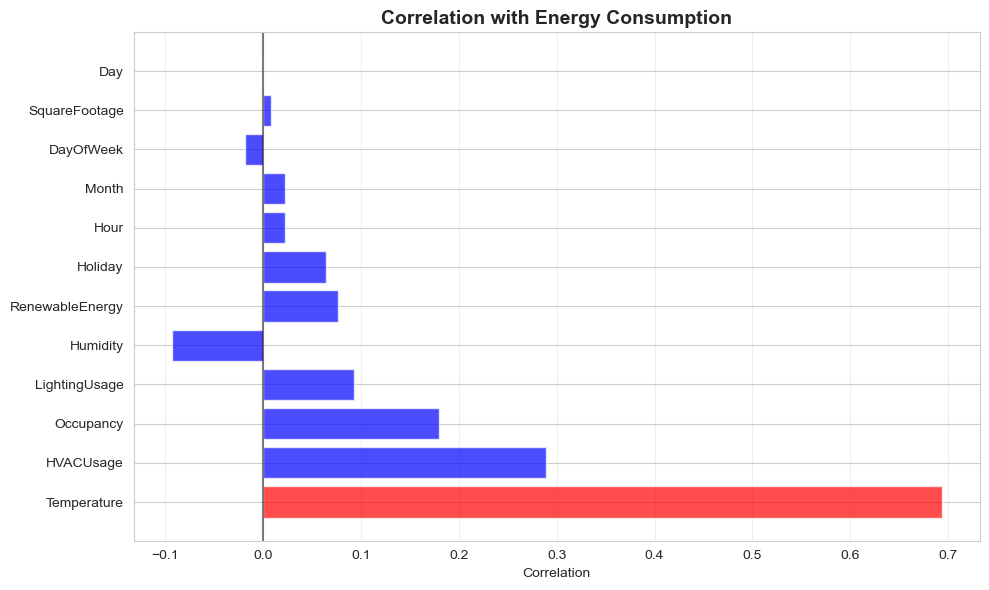

In [834]:
available_features = [col for col in numerical_features if col in data_clean.columns]
df_corr = data_clean[available_features]
correlation_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, square=True, mask=mask, fmt='.3f')
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

if 'EnergyConsumption' in correlation_matrix.columns:
    energy_corr = correlation_matrix['EnergyConsumption'].drop('EnergyConsumption')
    energy_corr = energy_corr.sort_values(key=abs, ascending=False)
    
    print("Correlations with EnergyConsumption:")
    print("-" * 40)
    for var, corr in energy_corr.items():
        print(f"{var:<15} | {corr:7.3f}")
    
    plt.figure(figsize=(10, 6))
    colors = ['red' if abs(x) > 0.5 else 'blue' for x in energy_corr.values]
    plt.barh(range(len(energy_corr)), energy_corr.values, color=colors, alpha=0.7)
    plt.yticks(range(len(energy_corr)), energy_corr.index)
    plt.xlabel('Correlation')
    plt.title('Correlation with Energy Consumption', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Categorical features

## Create new features

The relationship will be analyzed by seasonality. A new feature will be added to the original dataset. To preserve the original data unchanged, a copy of the data frame is created.



The average energy consumption values remain relatively stable across months, fluctuating between 75 and 78 throughout the year. This indicates that there is no significant variation in energy use based solely on the month.

A new column, Season, was introduced to capture potential seasonal patterns. However, the results show no substantial differences that would justify monthly analysis over seasonal analysis. This indicates that seasonal grouping captures the temporal variation adequately, making monthly granularity unnecessary.

In [130]:
#df = df.drop('Month', axis=1)

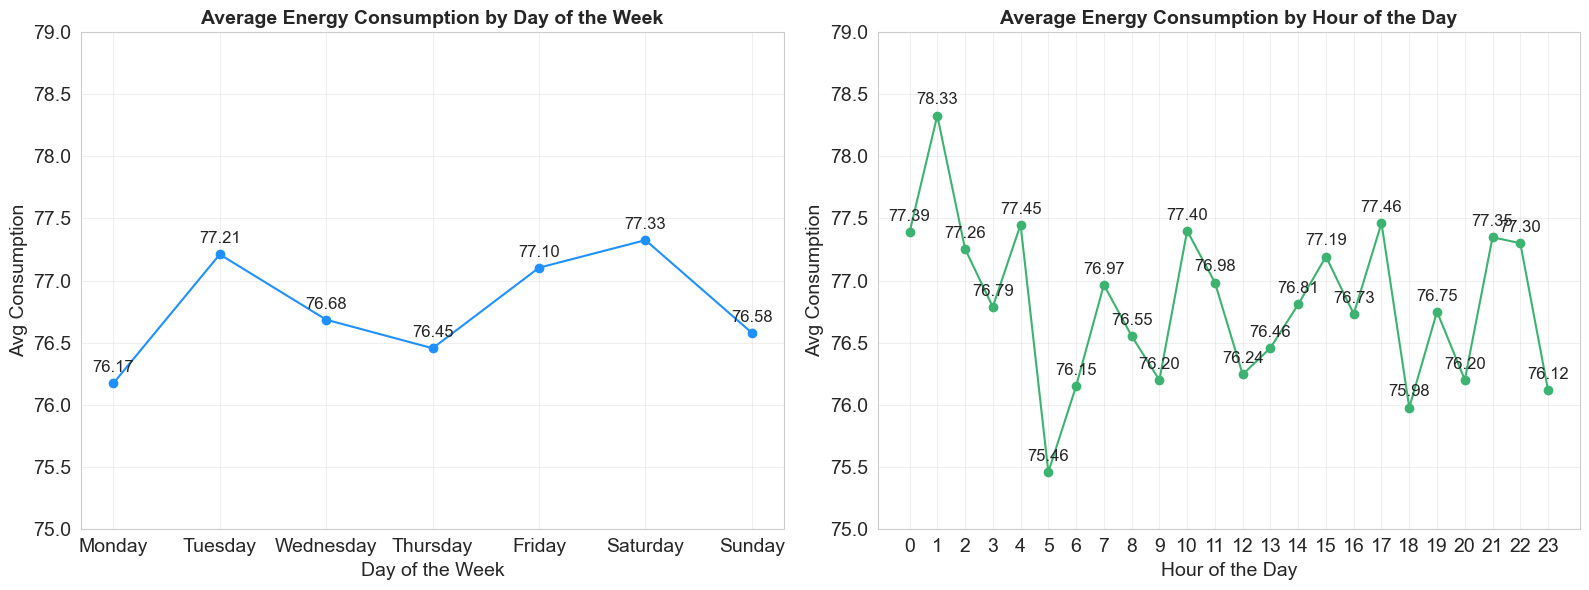

Daily: Max value: 77.33, Min value: 76.17
Hourly: Max value: 78.33, Min value: 75.46


In [132]:
daily_avg_consumption = df.groupby('DayOfWeek')['EnergyConsumption'].mean().reset_index()
hourly_avg_consumption = df.groupby('Hour')['EnergyConsumption'].mean().reset_index()

week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg_consumption['DayOfWeek'] = pd.Categorical(daily_avg_consumption['DayOfWeek'], categories=week_order, ordered=True)
daily_avg_consumption = daily_avg_consumption.sort_values('DayOfWeek')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("whitegrid")

# Daily
ax[0].plot(daily_avg_consumption['DayOfWeek'], daily_avg_consumption['EnergyConsumption'], 
           marker='o', color='dodgerblue')
ax[0].set_title('Average Energy Consumption by Day of the Week', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Day of the Week', fontsize=14)
ax[0].set_ylabel('Avg Consumption', fontsize=14)
ax[0].set_xticks(range(7))
ax[0].set_xticklabels(week_order, fontsize=14)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].grid(alpha=0.3)
for x, (label, y) in enumerate(zip(week_order, daily_avg_consumption['EnergyConsumption'])):
    ax[0].annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=12)

# Hourly
ax[1].plot(hourly_avg_consumption['Hour'], hourly_avg_consumption['EnergyConsumption'], 
           marker='o', color='mediumseagreen')
ax[1].set_title('Average Energy Consumption by Hour of the Day', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Hour of the Day', fontsize=14)
ax[1].set_ylabel('Avg Consumption', fontsize=14)
ax[1].set_xticks(range(0,24))
ax[1].set_xticklabels([str(h) for h in range(0,24)], fontsize=14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].grid(alpha=0.3)
for x, y in zip(hourly_avg_consumption['Hour'], hourly_avg_consumption['EnergyConsumption']):
    ax[1].annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=12)

ax[0].set_ylim(75, 79)

ax[0].set_ylim(75, 79)
ax[1].set_ylim(75, 79)
plt.tight_layout()
plt.show()

max_val_daily = daily_avg_consumption['EnergyConsumption'].max()
min_val_daily = daily_avg_consumption['EnergyConsumption'].min()
max_val_hourly = hourly_avg_consumption['EnergyConsumption'].max()
min_val_hourly = hourly_avg_consumption['EnergyConsumption'].min()

print(f"Daily: Max value: {max_val_daily:.2f}, Min value: {min_val_daily:.2f}")
print(f"Hourly: Max value: {max_val_hourly:.2f}, Min value: {min_val_hourly:.2f}")


The average energy consumption varies slightly across the days of the week, indicating energy usage is fairly consistent throughout the week.

When analysing average consumption throughout the day, greater variability can be seen. The hourly pattern suggests that there may be distinct periods of higher and lower energy use, possibly related to the buildings' usage cycles.

To study and simplify the effects of time of day, we can categorise consumption patterns into four groups, defined as:

- Morning: 6:00 a.m. to 12:00 p.m.
- Afternoon: 12:00 p.m. to 6:00 p.m.
- Evening: 6:00 p.m. to 9:00 p.m.
- Night: 9:00 p.m. to 6:00 a.m.

By generating this division, we reduce the number of features, decrease the complexity of the model, and at the same time retain meaningful information about energy consumption behaviour at different times of the day.


In [135]:
def get_time_period(hour):
    if 4 <= hour < 12:  
        return 'Morning'
    elif 12 <= hour < 16:  
        return 'Afternoon'
    elif 16 <= hour < 21:  
        return 'Evening'
    else:  
        return 'Night'

df['TimePeriod'] = df['Hour'].apply(get_time_period)
period_stats = df.groupby('TimePeriod')['EnergyConsumption'].agg(['mean', 'std']).reset_index()
print("Consumo promedio por período del día:")
print(period_stats)

Consumo promedio por período del día:
  TimePeriod    mean        std  
0  Afternoon  76.666492  9.583732
1    Evening  76.609086  9.059677
2    Morning  76.626756  9.131469
3      Night  77.206598  9.267437


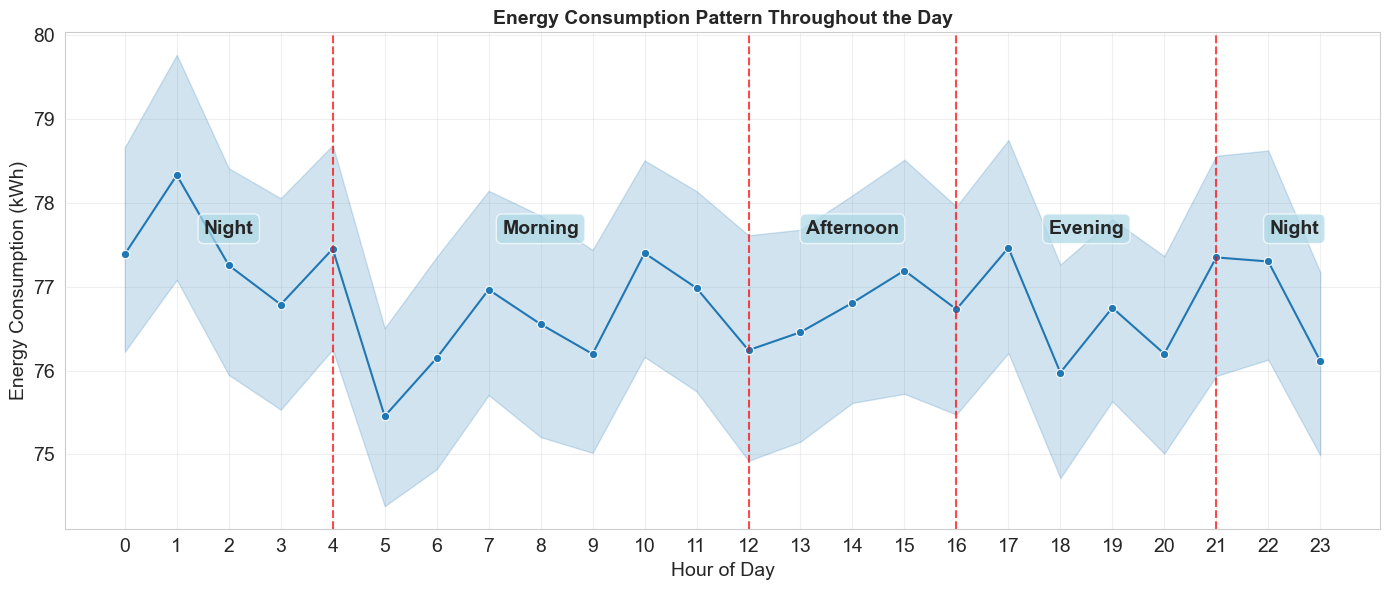

In [137]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

ax = sns.lineplot(data=df, x='Hour', y='EnergyConsumption', estimator='mean', errorbar=('ci', 95), marker='o')

for hour in [4, 12, 16, 21]: ax.axvline(x=hour, color='red', linestyle='--', alpha=0.7)
period_positions = [(2, 'Night'), (8, 'Morning'), (14, 'Afternoon'), (18.5, 'Evening'), (22.5, 'Night')]
ylim = ax.get_ylim()
for pos, name in period_positions: ax.text(
        pos, ylim[1]*0.97, name, ha='center',
        fontweight='bold', fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
ax.set_title('Energy Consumption Pattern Throughout the Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=14)

ax.set_xticks(range(0, 24))
ax.set_xticklabels([str(h) for h in range(0,24)], fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [138]:
# df = df.drop('Hour', axis=1)
df

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,EnergyConsumption,Season,TimePeriod
0,1,0,Saturday,No,25.139433,43.431581,1565.693999,5,On,Off,75.364373,Winter,Night
1,1,1,Saturday,No,27.731651,54.225919,1411.064918,1,On,On,83.401855,Winter,Night
2,1,2,Saturday,No,28.704277,58.907658,1755.715009,2,Off,Off,78.270888,Winter,Night
3,1,3,Saturday,No,20.080469,50.371637,1452.316318,1,Off,On,56.519850,Winter,Night
4,1,4,Saturday,No,23.097359,51.401421,1094.130359,9,On,Off,70.811732,Winter,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,12,6,Sunday,Yes,26.338718,52.580000,1563.567259,7,On,On,70.270344,Winter,Morning
4996,12,17,Monday,No,20.007565,42.765607,1999.982252,5,Off,On,73.943071,Winter,Evening
4997,12,13,Thursday,Yes,26.226253,30.015975,1999.982252,5,Off,On,85.784613,Winter,Afternoon
4998,12,8,Saturday,Yes,24.673206,50.223939,1240.811298,2,On,On,63.784001,Winter,Morning


Now, it is necessary to analyze whether the holidays add significant variations to the energy consumption analysis.

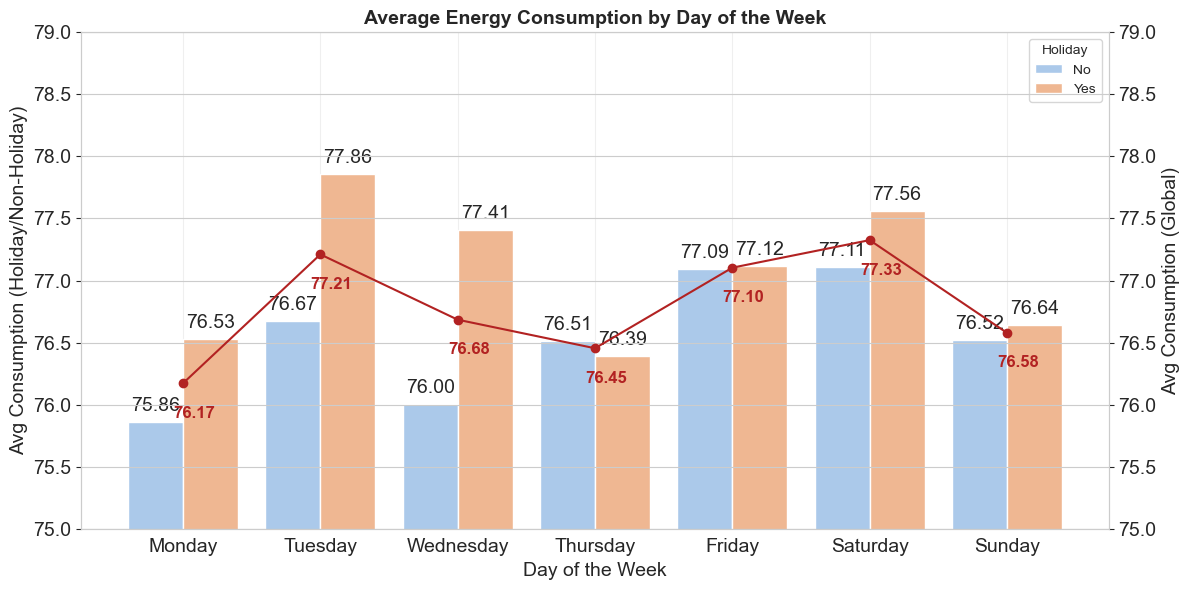

In [179]:
if df['Holiday'].dtype == 'O':  # object/string
    df['HolidayLabel'] = df['Holiday']
else:
    df['HolidayLabel'] = df['Holiday'].map({0: 'No', 1: 'Yes'})

holiday_avg = df.groupby(['DayOfWeek', 'HolidayLabel'])['EnergyConsumption'].mean().reset_index()

week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
holiday_avg['DayOfWeek'] = pd.Categorical(holiday_avg['DayOfWeek'], categories=week_order, ordered=True)
holiday_avg = holiday_avg.sort_values('DayOfWeek')


fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")

# Holiday vs Non-Holiday
sns.barplot(data=holiday_avg, x='DayOfWeek', y='EnergyConsumption', hue='HolidayLabel', palette='pastel', ax=ax1)
for container in ax1.containers:
    ax1.bar_label(container, labels=[f'{v:.2f}' for v in container.datavalues], padding=5, fontsize=14)

ax1.set_xlabel('Day of the Week', fontsize=14)
ax1.set_ylabel('Avg Consumption (Holiday/Non-Holiday)', fontsize=14)
ax1.set_title('Average Energy Consumption by Day of the Week', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.legend(title='Holiday')
ax1.set_ylim(75, 79)

ax2 = ax1.twinx()
ax2.plot(daily_avg_consumption['DayOfWeek'], daily_avg_consumption['EnergyConsumption'],
    marker='o', color='firebrick', label='Global Mean')
for x, y in zip(range(7), daily_avg_consumption['EnergyConsumption']):
    ax2.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(8,-27), ha='center', 
    va='bottom', fontsize=12, fontweight='bold', color='firebrick')
    
ax2.set_ylabel('Avg Consumption (Global)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylim(75, 79)

plt.tight_layout()
plt.show()

df = df.drop('HolidayLabel', axis=1)


The graph shows average energy consumption by day of the week, which remains relatively stable throughout the week. Energy consumption patterns do not vary significantly by day of the week.

The overall average remains between the values ​​of the holiday and non-holiday bars, suggesting that holidays raise the weekly average. On the other hand, consumption varies throughout the week, with peaks on Tuesdays and Saturdays, where overall values ​​have a similar trend to non-holidays, and these days have a marked difference between holidays and working days. This leads us to maintain both characteristics.

In [147]:
#qué tan lejos está la temperatura actual de una temperatura de "confort" ideal.
#🌡️ ¿Qué significa?
#22°C se considera una temperatura de confort térmico ideal para espacios interiores según estándares internacionales de climatización.

#Hipótesis clave:

#Temperaturas cercanas a 22°C → Menor consumo de HVAC
#Temperaturas lejanas a 22°C → Mayor consumo de HVAC (calefacción o aire acondicionado)

# Temperaturas ideales diferentes según estación
#df['TempFromComfort_Summer'] = np.abs(df['Temperature'] - 24)  # Verano más cálido
#df['TempFromComfort_Winter'] = np.abs(df['Temperature'] - 20)  # Invierno más frío

# O una versión más sofisticada
#def comfort_distance(temp, season):
#    comfort_temps = {'Summer': 24, 'Winter': 20, 'Spring': 22, 'Fall': 21}
#    return np.abs(temp - comfort_temps.get(season, 22))

#df['TempFromComfort_Seasonal'] = df.apply(
#    lambda row: comfort_distance(row['Temperature'], row['Season']), axis=1
#)

#df['HeatIndex'] = df['Temperature'] + (0.5 * df['Humidity'])

# Modelling

## Preprocessing

In [855]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 51 to 953
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        995 non-null    float64
 1   Humidity           995 non-null    float64
 2   SquareFootage      995 non-null    float64
 3   Occupancy          995 non-null    int64  
 4   HVACUsage          995 non-null    int32  
 5   LightingUsage      995 non-null    int32  
 6   RenewableEnergy    995 non-null    float64
 7   DayOfWeek          995 non-null    int8   
 8   Holiday            995 non-null    int32  
 9   EnergyConsumption  995 non-null    float64
 10  Hour               995 non-null    int32  
 11  Day                995 non-null    int32  
 12  Month              995 non-null    int32  
dtypes: float64(5), int32(6), int64(1), int8(1)
memory usage: 78.7 KB


In [857]:
data_clean.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month
51,22.124214,47.343916,1919.119996,6,0,0,5.352019,5,0,62.001894,3,3,1
72,25.080881,59.671534,1897.702224,8,0,0,14.391800,5,0,75.913906,0,4,1
97,20.979909,58.115629,1179.486192,9,0,0,8.577366,5,0,70.714362,1,5,1
185,29.954995,55.096539,1107.202980,5,0,0,26.994040,5,0,86.087469,17,8,1
228,28.298295,45.344931,1908.788264,0,0,0,11.433880,5,0,77.877691,12,10,1


In [859]:
numerical_features = [
    'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 
    'HVACUsage', 'LightingUsage', 'DayOfWeek', 
    'Holiday', 'Hour', 'Day', 'Month']

### Separate features and target variable and split (Train/Test)

In [862]:
X = data_clean[numerical_features]
y = data_clean['EnergyConsumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Dataset shape:", X.shape)
print("Target shape:", y.shape)

Dataset shape: (995, 11)
Target shape: (995,)


## Models


=== Model Performance ===
Model Comparison:
--------------------------------------------------
Linear Regression  | R²: 0.6188 | RMSE: 4.80
Ridge              | R²: 0.6188 | RMSE: 4.80
Random Forest      | R²: 0.5566 | RMSE: 5.18

Best model: Ridge


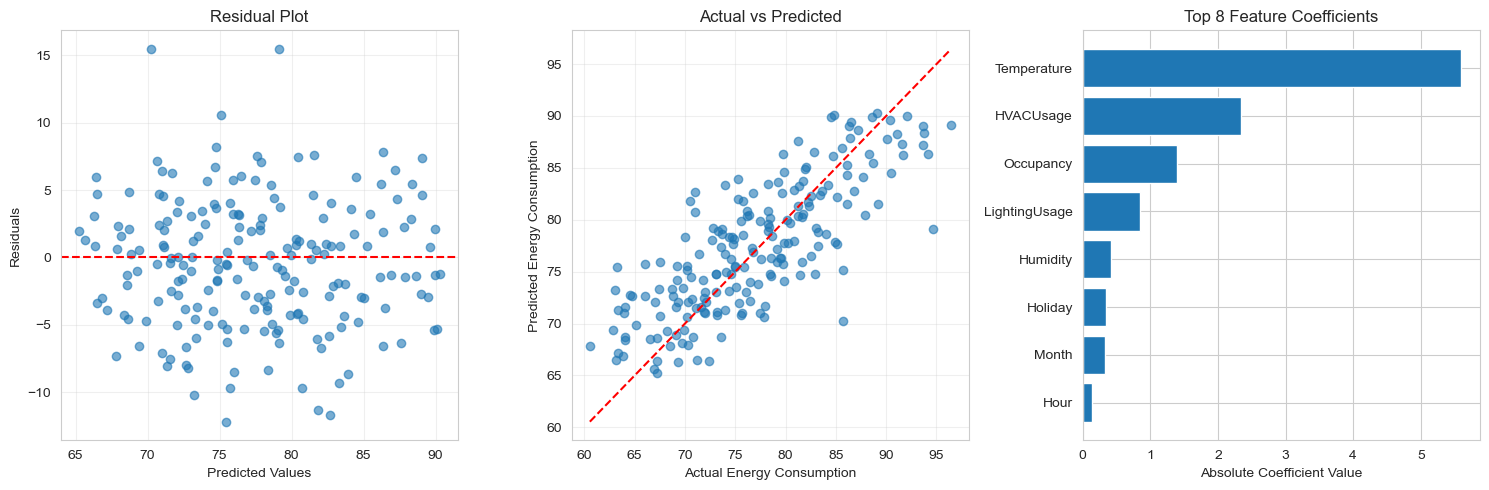

Trained model saved to: Ridge_model.pkl


In [871]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
predictions = {}

print(f"\n=== Model Performance ===")
print("Model Comparison:")
print("-" * 50)

for name, model in models.items():
    if name == 'Random Forest':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'R2': r2, 'RMSE': rmse, 'model': model}
    predictions[name] = y_pred
    print(f"{name:<18} | R²: {r2:.4f} | RMSE: {rmse:.2f}")

# Find the best model by R2
best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
best_model = results[best_model_name]['model']
y_pred_best = predictions[best_model_name]
print(f"\nBest model: {best_model_name}")

# Compute residuals for the best model
residuals = y_test - y_pred_best

# Feature importance or coefficients
if best_model_name in ['Linear Regression', 'Ridge']:
    feature_importance = best_model.coef_
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"X{i}" for i in range(X_train.shape[1])]
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': feature_importance,
        'abs_coefficient': np.abs(feature_importance)
    }).sort_values('abs_coefficient', ascending=False)
elif best_model_name == 'Random Forest':
    feature_importance = best_model.feature_importances_
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"X{i}" for i in range(X_train.shape[1])]
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance,
        'abs_importance': np.abs(feature_importance)
    }).sort_values('abs_importance', ascending=False)

# === Visualizations ===
plt.figure(figsize=(15, 5))

# 1. Residual plot
plt.subplot(1, 3, 1)
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)

# 2. Actual vs Predicted
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("Actual vs Predicted")
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.grid(True, alpha=0.3)

# 3. Feature importance plot
plt.subplot(1, 3, 3)
if best_model_name in ['Linear Regression', 'Ridge']:
    top_features = importance_df.head(8)
    plt.barh(range(len(top_features)), top_features['abs_coefficient'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.title("Top 8 Feature Coefficients")
    plt.xlabel("Absolute Coefficient Value")
    plt.gca().invert_yaxis()
elif best_model_name == 'Random Forest':
    top_features = importance_df.head(8)
    plt.barh(range(len(top_features)), top_features['abs_importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.title("Top 8 Feature Importances")
    plt.xlabel("Importance Value")
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Save the best model
model_path = f"{best_model_name.replace(' ', '_')}_model.pkl"
joblib.dump(best_model, model_path)
print(f"Trained model saved to: {model_path}")

In [873]:
df2 = pd.DataFrame({
    'y_test': y_test.values,    # use .values to avoid index issues
    'y_pred': y_pred
})

# If you want to keep the original indices:
# df2 = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Or, reset index if you want a clean 0-based index:
df2 = df2.reset_index(drop=True)

print(df2)

      y_test     y_pred  
0    63.216577  73.680875
1    66.001780  76.175200
2    94.178518  88.495948
3    68.805286  75.060082
4    77.452961  68.134778
..         ...        ...
194  78.408830  80.997519
195  78.254288  83.821785
196  73.129470  69.612043
197  74.862475  76.387563
198  67.391386  76.322426

[199 rows x 2 columns]
